# NutrIA – Reconnaissance d'aliments avec Deep Learning (Food-101)

Ce notebook a pour objectif de :
- Construire un modèle de deep learning pour reconnaître des aliments à partir d'images.
- Utiliser le *transfer learning* avec un modèle pré-entraîné (MobileNetV2).

## Résultats obtenus
| Métrique | Valeur |
|----------|--------|
| **Test Accuracy** | 74.84% |
| **Test Loss** | 0.94 |
| **Macro F1-Score** | 0.75 |

## 1️ Configuration de l'environnement
Installation des dépendances et vérification GPU.

In [1]:
!pip install --upgrade pip
!pip install "tensorflow[and-cuda]" tensorflow-datasets matplotlib pandas scikit-learn

## 2️ Chargement et exploration des données
Utilisation du dataset **Food-101** via TensorFlow Datasets :
- 101 catégories d'aliments
- 101,000 images au total
- Split : 75,750 train / 25,250 test

✅ TensorFlow version: 2.20.0
🖥️  GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

📥 Chargement du dataset Food-101...

Nombre de classes : 101
Exemples de classes : ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


2025-12-12 20:16:33.970003: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Aperçu tabulaire (train) :
         id  label_id           label_name
0  sample_0         8        bread_pudding
1  sample_1        45        frozen_yogurt
2  sample_2        82              ravioli
3  sample_3        91  spaghetti_carbonara
4  sample_4        13        caprese_salad

🔍 Exemple d'images du dataset :


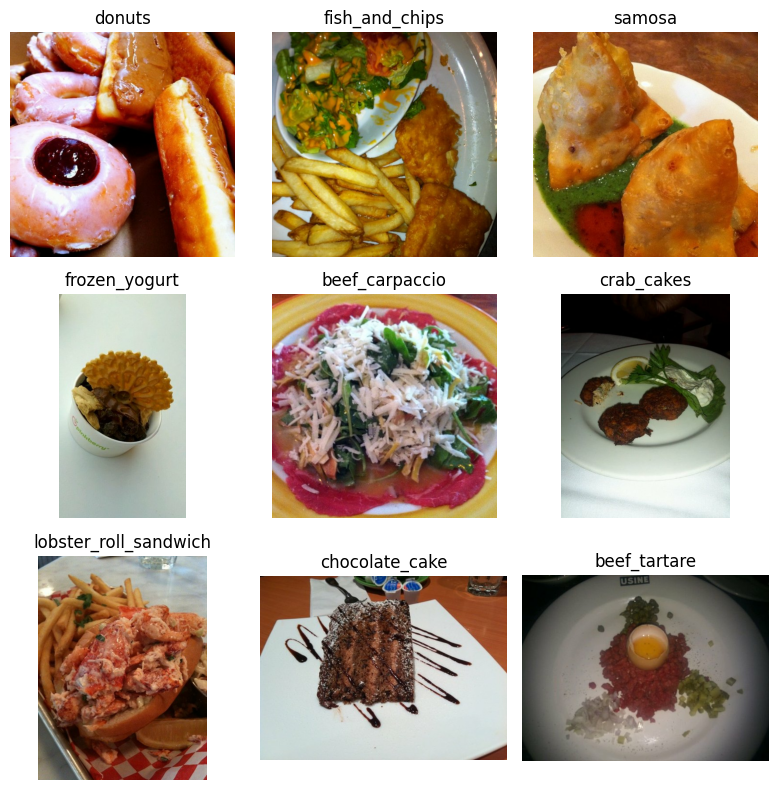


Taille estimée des splits :
Taille train (approx) : 68175
Taille val   (approx) : 7575
Taille test  (TFDS)   : 25250

✅ data_augmentation true

✅ Pipelines tf.data prêts (train / val / test).


In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models

print("✅ TensorFlow version:", tf.__version__)
print("🖥️  GPUs disponibles:", tf.config.list_physical_devices("GPU"))

gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("⚠️ Impossible de régler memory_growth pour ce GPU :", e)

AUTOTUNE   = tf.data.AUTOTUNE
IMG_SIZE   = (224, 224)
IMG_SHAPE  = IMG_SIZE + (3,)
BATCH_SIZE = 32

print("\n📥 Chargement du dataset Food-101...\n")

(ds_train_raw, ds_test_raw), ds_info = tfds.load(
    "food101",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

class_names = ds_info.features["label"].names
num_classes = len(class_names)

print(f"Nombre de classes : {num_classes}")
print("Exemples de classes :", class_names[:10])


def ds_to_dataframe(ds, max_samples=1000):
    file_ids = []
    labels   = []
    for i, (_, label) in enumerate(ds.take(max_samples)):
        file_ids.append(f"sample_{i}")
        labels.append(int(label.numpy()))
    df = pd.DataFrame({"id": file_ids, "label_id": labels})
    df["label_name"] = df["label_id"].apply(lambda i: class_names[i])
    return df


df_train_preview = ds_to_dataframe(ds_train_raw, max_samples=2000)
print("\nAperçu tabulaire (train) :")
print(df_train_preview.head())


def show_examples(ds, class_names, n=9):
    plt.figure(figsize=(8, 8))
    for i, (image, label) in enumerate(ds.take(n)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy())
        plt.title(class_names[int(label.numpy())])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


print("\n🔍 Exemple d'images du dataset :")
show_examples(ds_train_raw, class_names, n=9)

VAL_RATIO = 0.1

ds_train_size = ds_info.splits["train"].num_examples
val_size = int(VAL_RATIO * ds_train_size)

ds_val   = ds_train_raw.take(val_size)
ds_train = ds_train_raw.skip(val_size)

print("\nTaille estimée des splits :")
print("Taille train (approx) :", ds_train_size - val_size)
print("Taille val   (approx) :", val_size)
print("Taille test  (TFDS)   :", ds_info.splits["validation"].num_examples)

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label


# Data augmentation renforcée (ajout rotation)
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ],
    name="data_augmentation",
)

USE_dataAUG = True

def prepare_dataset(ds, training=True):
    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    if training and USE_dataAUG:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )
        ds = ds.shuffle(1000)
        print("\n✅ data_augmentation true")
    elif training:
        ds = ds.shuffle(1000)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds


train_ds = prepare_dataset(ds_train, training=True)
val_ds   = prepare_dataset(ds_val, training=False)
test_ds  = prepare_dataset(ds_test_raw, training=False)

print("\n✅ Pipelines tf.data prêts (train / val / test).")

## 3️ Construction et entraînement du modèle
**Stratégie** : Full Fine-Tuning de MobileNetV2
- Base : MobileNetV2 pré-entraîné sur ImageNet
- Toutes les couches dégelées (trainable=True)
- Head personnalisé avec Dropout pour la régularisation

In [17]:
# -----------------------------------------------------------
# --- MODÈLE & ENTRAÎNEMENT (FULL FT + RÉGULARISATION) ---
# -----------------------------------------------------------

# 1. Chargement du modèle de base (MobileNetV2)
print("\n🔄 Chargement de MobileNetV2...")
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet",
)

# 2. Dégele de toutes les couches (FULL FINE-TUNING)
base_model.trainable = True

print("\n Le modèle est entièrement dégelé (trainable=True).")
print("Nombre de couches: ", len(base_model.layers))

# 3. Ajout d'une couche head (Dropout + Dense + L2)
inputs  = tf.keras.Input(shape=IMG_SHAPE)
x       = base_model(inputs, training=True)
x       = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x       = layers.Dropout(0.3)(x)
x       = layers.Dense(256, activation="relu")(x)
x       = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, outputs, name="CaloriIA_MobileNetV2_FullFT_Regularized")

print("\n Architecture du head :")
print("GlobalAvgPool → Dropout(0.3) → Dense(256) → Dropout(0.3) → Dense(101)")

# 4. Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "models/caloriia_FullFT_Regularized_best.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    mode="min",
    verbose=1,
)
#Ajout de callback pour réduire le learning rate
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,
)

# 5. Compilation avec LR=1e-5
print("\n⚙️ Compilation avec LR=5e-5...")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()


🔄 Chargement de MobileNetV2...



 Le modèle est entièrement dégelé (trainable=True).
Nombre de couches:  154

 Architecture du head :
GlobalAvgPool → Dropout(0.3) → Dense(256) → Dropout(0.3) → Dense(101)

⚙️ Compilation avec LR=5e-5...


Model: "CaloriIA_MobileNetV2_FullFT_Regularized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,611,877 (9.96 MB)

 Trainable params: 2,577,765 (9.83 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [18]:
EPOCHS = 20

# 6. Train
print(f"\n Démarrage du training sur {EPOCHS} epochs...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)


 Démarrage du training sur 20 epochs...
Epoch 1/20


2025-12-12 20:17:51.521379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 312 of 1000
2025-12-12 20:17:56.326464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 619s 255ms/step - accuracy: 0.2206 - loss: 3.4630 - val_accuracy: 0.4304 - val_loss: 2.2816 - learning_rate: 5.0000e-05
Epoch 2/20


2025-12-12 20:27:41.722220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 265 of 1000
2025-12-12 20:27:46.820913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 515s 234ms/step - accuracy: 0.4574 - loss: 2.2154 - val_accuracy: 0.4532 - val_loss: 2.1848 - learning_rate: 5.0000e-05
Epoch 3/20


2025-12-12 20:36:16.288140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 315 of 1000
2025-12-12 20:36:20.995588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 510s 232ms/step - accuracy: 0.5413 - loss: 1.8472 - val_accuracy: 0.5526 - val_loss: 1.7770 - learning_rate: 5.0000e-05
Epoch 4/20


2025-12-12 20:44:46.241295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 313 of 1000
2025-12-12 20:44:51.301592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 517s 235ms/step - accuracy: 0.5833 - loss: 1.6490 - val_accuracy: 0.5662 - val_loss: 1.7222 - learning_rate: 5.0000e-05
Epoch 5/20


2025-12-12 20:53:23.027087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 349 of 1000
2025-12-12 20:53:27.892162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 509s 232ms/step - accuracy: 0.6162 - loss: 1.5106 - val_accuracy: 0.6053 - val_loss: 1.5116 - learning_rate: 5.0000e-05
Epoch 6/20


2025-12-12 21:01:51.742874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 345 of 1000
2025-12-12 21:01:56.574342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 525s 239ms/step - accuracy: 0.6418 - loss: 1.3994 - val_accuracy: 0.6189 - val_loss: 1.4876 - learning_rate: 5.0000e-05
Epoch 7/20


2025-12-12 21:10:37.024763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 376 of 1000
2025-12-12 21:10:41.656720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 517s 236ms/step - accuracy: 0.6629 - loss: 1.3110 - val_accuracy: 0.6268 - val_loss: 1.4658 - learning_rate: 5.0000e-05
Epoch 8/20


2025-12-12 21:19:14.058250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 336 of 1000
2025-12-12 21:19:18.787267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 507s 231ms/step - accuracy: 0.6770 - loss: 1.2437 - val_accuracy: 0.6656 - val_loss: 1.2727 - learning_rate: 5.0000e-05
Epoch 9/20


2025-12-12 21:27:40.764775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 356 of 1000
2025-12-12 21:27:45.313821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 523s 238ms/step - accuracy: 0.6931 - loss: 1.1795 - val_accuracy: 0.6446 - val_loss: 1.3993 - learning_rate: 5.0000e-05
Epoch 10/20


2025-12-12 21:36:23.464593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 321 of 1000
2025-12-12 21:36:28.426122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 507s 231ms/step - accuracy: 0.7035 - loss: 1.1230 - val_accuracy: 0.6741 - val_loss: 1.2724 - learning_rate: 5.0000e-05
Epoch 11/20


2025-12-12 21:44:50.144854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 442 of 1000
2025-12-12 21:44:54.167697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 520s 237ms/step - accuracy: 0.7156 - loss: 1.0762 - val_accuracy: 0.6902 - val_loss: 1.1837 - learning_rate: 5.0000e-05
Epoch 12/20


2025-12-12 21:53:30.303325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 329 of 1000
2025-12-12 21:53:35.108862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 506s 230ms/step - accuracy: 0.7262 - loss: 1.0348 - val_accuracy: 0.6795 - val_loss: 1.2390 - learning_rate: 5.0000e-05
Epoch 13/20
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 550s 228ms/step - accuracy: 0.7346 - loss: 0.9950 - val_accuracy: 0.6915 - val_loss: 1.1875 - learning_rate: 5.0000e-05
Epoch 14/20


2025-12-12 22:11:06.537161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 297 of 1000
2025-12-12 22:11:11.267900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 514s 234ms/step - accuracy: 0.7431 - loss: 0.9595 - val_accuracy: 0.6673 - val_loss: 1.2946 - learning_rate: 5.0000e-05
Epoch 15/20


2025-12-12 22:19:40.242573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 402 of 1000
2025-12-12 22:19:44.650833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 508s 231ms/step - accuracy: 0.7526 - loss: 0.9222 - val_accuracy: 0.7179 - val_loss: 1.0617 - learning_rate: 5.0000e-05
Epoch 16/20
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 548s 228ms/step - accuracy: 0.7586 - loss: 0.8964 - val_accuracy: 0.6825 - val_loss: 1.2343 - learning_rate: 5.0000e-05
Epoch 17/20


2025-12-12 22:37:16.289026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 292 of 1000
2025-12-12 22:37:21.249477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 510s 232ms/step - accuracy: 0.7650 - loss: 0.8708 - val_accuracy: 0.7476 - val_loss: 0.9453 - learning_rate: 5.0000e-05
Epoch 18/20


2025-12-12 22:45:45.866370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 358 of 1000
2025-12-12 22:45:50.528911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 516s 235ms/step - accuracy: 0.7747 - loss: 0.8331 - val_accuracy: 0.7267 - val_loss: 1.0351 - learning_rate: 5.0000e-05
Epoch 19/20


2025-12-12 22:54:22.020765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 384 of 1000
2025-12-12 22:54:26.455300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 504s 230ms/step - accuracy: 0.7794 - loss: 0.8090 - val_accuracy: 0.7483 - val_loss: 0.9784 - learning_rate: 5.0000e-05
Epoch 20/20


2025-12-12 23:03:44.026662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:15468: Filling up shuffle buffer (this may take a while): 323 of 1000
2025-12-12 23:03:48.897889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2131/2131 ━━━━━━━━━━━━━━━━━━━━ 560s 229ms/step - accuracy: 0.7838 - loss: 0.7898 - val_accuracy: 0.7352 - val_loss: 1.0040 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 17.


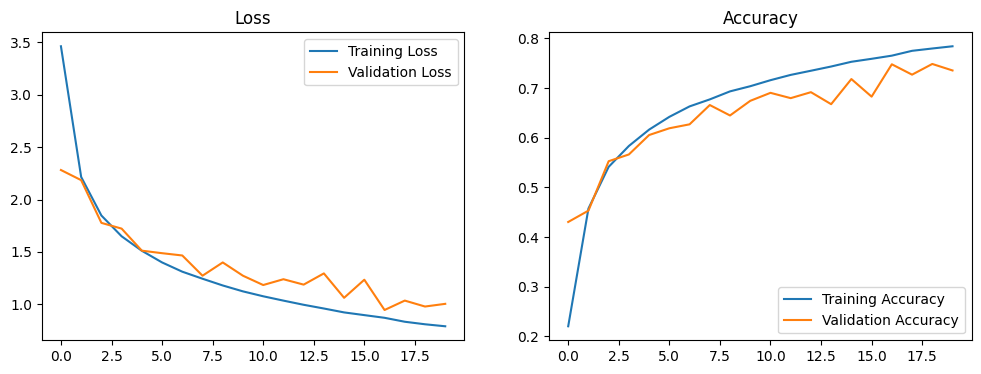

In [19]:
# 7. Plot History
def plot_history(history, title="Training History"):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs_range = range(len(loss))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.show()

plot_history(history, title="Full Fine-Tuning with Regularization")

## 4️ Évaluation des performances
Évaluation sur le jeu de test (25,250 images non vues pendant l'entraînement).

In [20]:
# 8. Evaluation sur le test set
print("\n🧪 ÉVALUATION FINALE SUR LE TEST SET...")
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


🧪 ÉVALUATION FINALE SUR LE TEST SET...
  1/790 ━━━━━━━━━━━━━━━━━━━━ 2:22 181ms/step - accuracy: 0.7500 - loss: 0.7314

790/790 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step - accuracy: 0.7484 - loss: 0.9453
✅ Test Accuracy: 0.7484
✅ Test Loss: 0.9453


In [21]:
# 9. Classification Report
print("\n Génération du classification report...")
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))


 Génération du classification report...
                         precision    recall  f1-score   support

              apple_pie       0.63      0.44      0.52       250
         baby_back_ribs       0.69      0.82      0.75       250
                baklava       0.84      0.83      0.83       250
         beef_carpaccio       0.75      0.84      0.79       250
           beef_tartare       0.81      0.74      0.77       250
             beet_salad       0.52      0.71      0.60       250
               beignets       0.70      0.87      0.77       250
               bibimbap       0.93      0.84      0.88       250
          bread_pudding       0.61      0.44      0.51       250
      breakfast_burrito       0.71      0.62      0.66       250
             bruschetta       0.65      0.68      0.67       250
           caesar_salad       0.85      0.80      0.83       250
                cannoli       0.89      0.79      0.84       250
          caprese_salad       0.70      0.82    


 Génération de la matrice de confusion...

📉 Matrice de confusion (normalisée) – 15 premières classes :


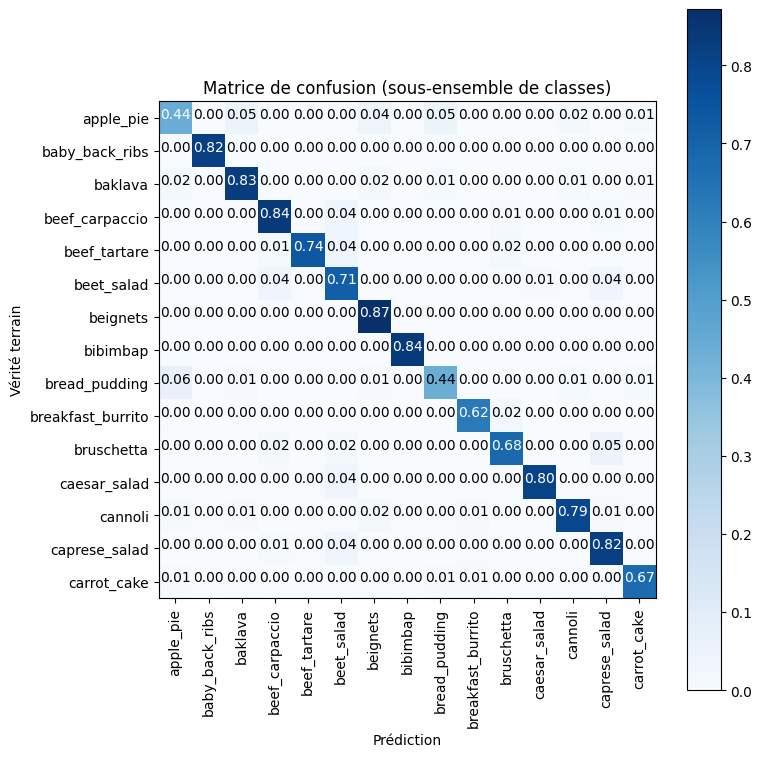

In [22]:
# 10. Matrice de confusion
print("\n Génération de la matrice de confusion...")
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)


def plot_confusion_matrix(cm, class_names, normalize=True, max_classes=15):
    num_classes = min(len(class_names), max_classes)
    cm_plot = cm[:num_classes, :num_classes]
    labels_plot = class_names[:num_classes]

    plt.figure(figsize=(8, 8))
    plt.imshow(cm_plot, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Matrice de confusion (sous-ensemble de classes)")
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, labels_plot, rotation=90)
    plt.yticks(ticks=tick_marks, labels=labels_plot)

    fmt = ".2f" if normalize else "d"
    thresh = cm_plot.max() / 2.0
    for i, j in itertools.product(range(cm_plot.shape[0]), range(cm_plot.shape[1])):
        plt.text(
            j,
            i,
            format(cm_plot[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm_plot[i, j] > thresh else "black",
        )

    plt.ylabel("Vérité terrain")
    plt.xlabel("Prédiction")
    plt.tight_layout()
    plt.show()


print("\n📉 Matrice de confusion (normalisée) – 15 premières classes :")
plot_confusion_matrix(cm_norm, class_names, normalize=True, max_classes=15)

In [24]:
import os

os.makedirs("models", exist_ok=True)

MODEL_PATH = "models/mobilenetv2_v3_FullFT_Regularized.keras"
model.save(MODEL_PATH)

print(f"✅ Modèle sauvegardé : {MODEL_PATH}")

✅ Modèle sauvegardé : models/mobilenetv2_v3_FullFT_Regularized.keras


---

## Conclusion

### Résultats finaux
- **Test Accuracy** : 74.84% sur 25,250 images
- **Test Loss** : 0.94
- **Macro F1-Score** : 0.75

### Architecture retenue
```
Input (224×224×3)
    ↓
MobileNetV2 (ImageNet, Full Fine-Tuning)
    ↓
GlobalAveragePooling2D
    ↓
Dropout(0.3) → Dense(256, ReLU) → Dropout(0.3)
    ↓
Dense(101, Softmax)
```

### Hyperparamètres optimaux
| Paramètre | Valeur |
|-----------|--------|
| Optimizer | Adam |
| Learning Rate | 5e-5 |
| Batch Size | 32 |
| Epochs | 20 |
| Régularisation | Dropout(0.3) |

### Apprentissages clés
1. **Full Fine-Tuning** surpasse le Feature Extraction sur ce dataset volumineux
2. **Dropout(0.3)** offre une régularisation efficace sans pénaliser la convergence
3. **Learning rate très bas (5e-5)** essentiel pour ne pas détruire les poids pré-entraînés

---
*Notebook réalisé par Samy BENIDDIR – Certification Dev IA Alyra 2025*